## an algorithm a day...

Initial "population": some $X,y$.

   1. fit a multidim Gaussian MAC to the $X$, weighted towards the good $y$ ones. (The simpler alternative would be to just fit the MAC to $X$ alone, but the weighting towards good points should improve the algorithm's cornering abilities).
   
   1. use MAC's eigenshit to orient axes, gives $X^\prime$
   
   1. fit a GP to the data points $(X^\prime,y)$. The idea is that the rotation $X \rightarrow X^\prime$ makes life easy for a generic GP covariance function with independent length scale hyperparameters for each of its axes.
   
   1. generate lots of samples from the MAC (perhaps with double the twice the variance or whatever, so we consider further afield), and choose the one that the GP asserts has the  highest EI.
   
   1. evaluate y at the new point and add to the population.
   
   1. delete someone from the population. It can't just be the worst, because bad points provide tabu. SEVERAL OPTIONS HERE:
      1. the oldest survivor!
      1. the one which would generate the most EI at its location, should it be deleted. (ie. proxy for how much that point is influencing future decisions).
      1. there might be some brainy GP trick for how "support vector-y" each data point is...


In [53]:
%matplotlib inline
import math, time
import numpy as np
from numpy import random as rng
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcess
from scipy import stats
from matplotlib import cm
np.set_printoptions(precision = 4)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
rng.seed(int(1000*time.clock()))

In [54]:
# Standard normal distribution functions
phi = stats.distributions.norm().pdf
PHI = stats.distributions.norm().cdf
PHIinv = stats.distributions.norm().ppf

# A few constants
lim = 8.

def g(x):
    """The function to predict """
    val = 5.0 * np.log(np.abs(x[:,0])+0.25)  - 0.01*np.power(lim/2+x[:,1],2.0)
    return -val

In [55]:
def random_rotation(C, angle):
    invC = np.linalg.inv(C)
    R = np.array([[math.cos(angle),-math.sin(angle)],[math.sin(angle),math.cos(angle)]]) # rotation matrix
    invC = np.dot(np.linalg.inv(R), np.dot(invC, R))
    C = np.linalg.inv(invC)
    return invC, C

diag_val, off_diag_val = 5.0, 4.5
C = np.array([[diag_val, off_diag_val], [off_diag_val,diag_val]])
Mu = 2*rng.normal(size=2) 
#print ('Covariance matrix: \n %s' % str(C))
angle = rng.random() * math.pi
C, invC = random_rotation(C, angle)
#print ('Covariance matrix: \n %s' % str(C))
X = 0.1*lim * rng.multivariate_normal(Mu, C, 10)

In [56]:
# Observations
y = g(X)

In [57]:
# Instantiate and fit a Gaussian Process Model
gp = GaussianProcess(corr='squared_exponential',
                     theta0=[0.1] * 2, thetaL=[1e-2] * 2,
                     thetaU=[100] * 2, nugget=0.000005, optimizer='Welch')


#gp = GaussianProcess(theta0=0.1, thetaL=.001, thetaU=1., corr='squared_exponential')
params = gp.get_params()
print('\t', params['theta0'])
# Fit the GP model to the data, performing maximum likelihood estimation
gp.fit(X, y)
print('-------------------------------------')

params = gp.get_params()
print('\t', params['theta0']) # bullshit, the params don't seem to change at all!
print('and now ', gp.theta_)
print ("best-fit theta =", gp.theta_[0, 0])

	 [0.1, 0.1]
-------------------------------------
	 [[ 0.1  0.1]]
and now  [[ 0.0801  0.01  ]]
best-fit theta = 0.0800955879564


In [58]:
# Evaluate real function, the prediction and its MSE on a grid
res = 100
x1, x2 = np.meshgrid(np.linspace(- lim, lim, res),
                     np.linspace(- lim, lim, res))
xx = np.vstack([x1.reshape(x1.size), x2.reshape(x2.size)]).T
# xx has res^2 rows (one for each pixel), and 2 columns (the x and y vals)
y_true = g(xx)  # the true function
y_pred, MSE = gp.predict(xx, eval_MSE=True)  # the gp predicted means and variances
# Those will be res^2 rows, 1 column
sigma = np.sqrt(MSE)
# now reconvert them from to "image" shapes
y_true = y_true.reshape((res, res))
y_pred = y_pred.reshape((res, res))
sigma = sigma.reshape((res, res))
u = (y_pred - np.mean(y))/sigma

best_so_far = np.max(y)
u = (y_pred - best_so_far)/sigma

#Phi = 0.5*erf(u/sqrt(2)) + 0.5
#phi = 1.0/sqrt(2*pi) * exp(-pow(u,2)/2.0)

EI = sigma*(u*PHI(u)  + phi(u))
EI = EI.reshape((res, res))

In [59]:
def plot_it(ax, f, txt):
    ax.axes.set_aspect('equal')
    #plt.xticks([])
    #plt.yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    cax = plt.contourf(f, cmap=cm.gray, alpha=0.65, extent=(- lim, lim, - lim, lim))
    #plt.clabel(cax, inline=1, fontsize=10)

    plt.title(txt)
    norm = plt.matplotlib.colors.Normalize(vmin=0., vmax=0.9)
    #cb = plt.colorbar(cax, norm=norm)
    #cb.set_label('${\\rm \mathbb{P}}\left[\widehat{G}(\mathbf{x}) \leq 0\\right]$')

    #plt.plot(X[y <= 0, 0], X[y <= 0, 1], 'r.', markersize=12)
    #plt.plot(X[y > 0, 0], X[y > 0, 1], 'b.', markersize=12)
    
    normed_y = y - y.min()
    normed_y = (normed_y / normed_y.max())
    for i,z in enumerate(X):
        plt.plot(z[0], z[1], '.', markersize=12, color=[1-normed_y[i],0,normed_y[i]])    

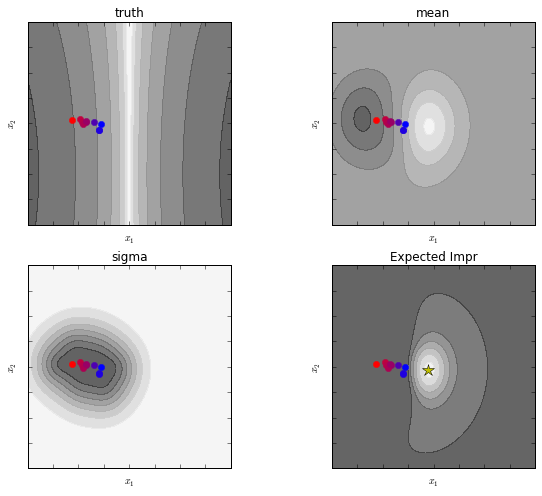

Wrote test74.png


In [60]:
# Get ready to plot the predictions etc.
plt.clf()
fig = plt.figure(1)
#--------------------------------------
ax = fig.add_subplot(221)
plot_it(ax, y_true, 'truth')
#--------------------------------------
ax = fig.add_subplot(222)
plot_it(ax, y_pred, 'mean')
#--------------------------------------
ax = fig.add_subplot(223)
plot_it(ax, sigma, 'sigma')
#--------------------------------------
ax = fig.add_subplot(224)
plot_it(ax, EI, 'Expected Impr')

best = xx[np.argmax(EI)]
plt.plot(best[0], best[1],'*y',markersize=12)

#--------------------------------------------
plt.show()
filename = ('test%d.png' % rng.randint(100))
fig.savefig(filename)
print ('Wrote %s' % filename)